Example of anomaly detection using symmetric Variational Autoencoder as in
 Pu, Yunchen, et al. "Symmetric variational autoencoder and connections to adversarial learning." arXiv preprint arXiv:1709.01846 (2017).

In [1]:
using PyPlot, FileIO, AnomalyDetection, EvalCurves, Flux
import PyPlot: plot
include("./plots.jl")

┌ Info: Precompiling AnomalyDetection [2069a70b-aa58-5cc0-a11c-32e347b774c5]
└ @ Base loading.jl:1187
┌ Info: Precompiling FluxExtensions [76425322-8995-11e8-0106-93ec95767fb2]
└ @ Base loading.jl:1187


loaded


PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld2")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels;
nX = X[:,Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# sVAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2
N = size(nX,2)

# setup the VAE object
ensize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
decsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
dissize = [indim + latentdim; hiddendim; hiddendim; 1] # discriminator architecture
lambda = 0.0 # weight of the data error term
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 10000
cbit = 5000 # after this number of iteratiosn, callback is printed
batchsize = 50 # batchsize 
nepochs = Int(ceil(batchsize*iterations/size(nX,2))) # if this is supplied, do epoch training
verbfit = true
M = 1 #  number of samples of X in reconstruction error
activation = Flux.relu
layer = Flux.Dense
rdelta = 1e-4 # reconstruction error threshold for training stopping
alpha = 0.5 # weighs between reconstruction error and discriminator score for classification
# 0 = only reconstruction error, 1 = only discriminator score
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
xsigma = 1.0 # static estimate of data variance
eta = 0.001
model = sVAEmodel(ensize, decsize, dissize; lambda=lambda, threshold=threshold, 
    contamination=contamination, iterations=iterations, cbit=cbit, nepochs = nepochs,
    verbfit=verbfit, batchsize=batchsize, 
    M = M, activation = activation, rdelta = rdelta, Beta = Beta, xsigma = xsigma,
    tracked = tracked, layer = layer, eta = eta)

sVAEmodel(sVAE(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 2)), Chain(Dense(4, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 1)), Chain(Dense(4, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 1))), 0.0, 0, 0.1262135922330097, 10000, 5000, 5556, 50, 1, true, 0.0001, 0.5, 1.0, 1.0, MVHistory{ValueHistories.History}, 0.001)

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX)

discriminator loss: 1.4339455
VAE loss: -0.0441913
reconstruction error: 0.9192129



Progress:   0%|                                         |  ETA: 1 days, 3:15:00
  discriminator loss:    1.4131546
  vae loss:              -0.018477902
Progress:   1%|                                         |  ETA: 0:14:19
  discriminator loss:    1.3651965
  vae loss:              0.2607654
Progress:   2%|█                                        |  ETA: 0:08:05
  discriminator loss:    1.2650543
  vae loss:              0.28938204
Progress:   3%|█                                        |  ETA: 0:05:42
  discriminator loss:    1.3624513
  vae loss:              0.05957081
Progress:   4%|██                                       |  ETA: 0:04:27
  discriminator loss:    1.3682033
  vae loss:              0.052369714
Progress:   5%|██                                       |  ETA: 0:03:41
  discriminator loss:    1.4250114
  vae loss:              -0.0042173155
Progress:   6%|██                                       |  ETA: 0:03:09
  discriminator loss:    1.3373573
  vae loss:           

Progress:  42%|█████████████████                        |  ETA: 0:00:33
  discriminator loss:    1.3907166
  vae loss:              0.0136841405
Progress:  43%|██████████████████                       |  ETA: 0:00:32
  discriminator loss:    1.3959131
  vae loss:              -0.0021487707
Progress:  44%|██████████████████                       |  ETA: 0:00:31
  discriminator loss:    1.3803446
  vae loss:              -0.0039166687
Progress:  44%|██████████████████                       |  ETA: 0:00:30
  discriminator loss:    1.3858812
  vae loss:              -0.001973935
Progress:  45%|███████████████████                      |  ETA: 0:00:30
  discriminator loss:    1.3686962
  vae loss:              0.057000622
Progress:  46%|███████████████████                      |  ETA: 0:00:29
  discriminator loss:    1.3731344
  vae loss:              0.08278505
Progress:  47%|███████████████████                      |  ETA: 0:00:28
  discriminator loss:    1.4146519
  vae loss:             

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:08
  discriminator loss:    1.1828076
  vae loss:              0.48302916
Progress:  84%|██████████████████████████████████       |  ETA: 0:00:07
  discriminator loss:    1.1717769
  vae loss:              0.5296768
Progress:  84%|███████████████████████████████████      |  ETA: 0:00:07
  discriminator loss:    1.1299057
  vae loss:              0.5943103
Progress:  85%|███████████████████████████████████      |  ETA: 0:00:07
  discriminator loss:    1.2841015
  vae loss:              0.37468758
Progress:  86%|███████████████████████████████████      |  ETA: 0:00:06
  discriminator loss:    1.0832818
  vae loss:              0.5775467
Progress:  87%|████████████████████████████████████     |  ETA: 0:00:06
  discriminator loss:    1.2308517
  vae loss:              0.58240956
Progress:  88%|████████████████████████████████████     |  ETA: 0:00:05
  discriminator loss:    1.1047821
  vae loss:              0.675627
Prog

discriminator loss: 1.2038472
VAE loss: 0.6860635
reconstruction error: 0.13418955



Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00
  discriminator loss:    1.1597612
  vae loss:              0.81618345
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
  discriminator loss:    1.1160023
  vae loss:              0.969718
  reconstruction error:  0.14816901


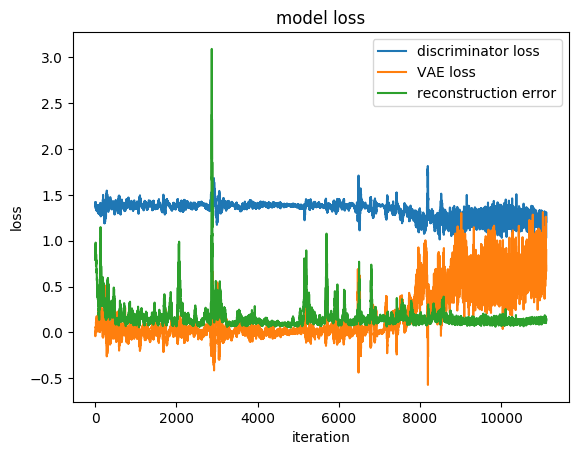

In [5]:
# plot model loss
plot(model)
show()

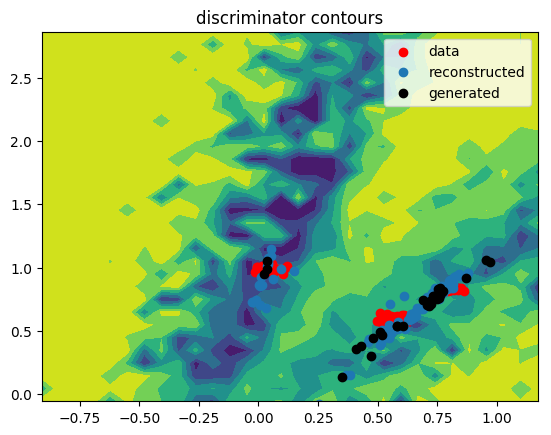

In [6]:
# plot recosntructed and generated samples
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)
Xrec = Flux.Tracker.data(model(X[:, Y.==0]))
Xgen = AnomalyDetection.generate(model, 30)

# also heatmap of the discriminator score
x = range(xl[1], stop=xl[2], length=30)
y = range(yl[1], stop=yl[2], length=30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        _x = AnomalyDetection.Float.([x[j], y[i]])
        _z = AnomalyDetection.getcode(model, _x)
        zz[i,j] = Flux.Tracker.data(AnomalyDetection.discriminate(model, _x, _z))[1]
    end
end

f = figure()
contourf(x, y, zz)
scatter(X[1, Y.==0], X[2, Y.==0], c = "r", label = "data")
scatter(Xrec[1,:], Xrec[2,:], label = "reconstructed")
scatter(Xgen[1,:], Xgen[2,:], c = "k", label = "generated")
title("discriminator contours")
xlim(xl)
ylim(yl)
legend()
show()

In [7]:
model(nX)

Tracked 2×90 Array{Float32,2}:
 0.701236  0.277915  0.70655   0.515156  …  0.30667    0.546748  0.584352
 0.659335  0.748248  0.714711  0.415214     0.0159366  0.530881  0.538727

In [8]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [9]:
AnomalyDetection.mu(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.162615  -0.162615  -0.162615  …  -0.162615  -0.162615  -0.162615
  0.103825   0.103825   0.103825      0.103825   0.103825   0.103825

In [10]:
AnomalyDetection.sigma(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.974234  0.974234  0.974234  0.974234  …  0.974234  0.974234  0.974234
 1.00797   1.00797   1.00797   1.00797      1.00797   1.00797   1.00797 

In [11]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.542226  1.23103   -0.437507   …  0.0505462  -0.0146043  -0.29107 
 -1.29281   0.243871  -0.0812126     1.51732    -0.441558   -0.802855

In [12]:
# predict labels
AnomalyDetection.setthreshold!(model, X)
model.M = 20 # number of samples - for classification higher is better (more stable)
global tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 1
 0
 1
 0
 1
 0
 1
 1
 0
 1

In [13]:
AnomalyDetection.anomalyscore(model, X)

103-element Array{Float32,1}:
 0.20555425 
 0.37348014 
 0.33251405 
 0.25698626 
 0.19935024 
 0.133724   
 0.2917168  
 0.34484828 
 0.36611566 
 0.10256789 
 0.4557974  
 0.34254187 
 0.3149656  
 ⋮          
 0.16226803 
 2.1848779  
 1.7216191  
 0.12232269 
 1.1125921  
 0.15724158 
 0.4614418  
 0.096951574
 0.68223804 
 0.4929049  
 0.46902597 
 0.5796367  

In [14]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 7
  tn = 88
  fp = 2
  fn = 6
precision: 0.7777777777777778
f1score: 0.6363636363636364
recall: 0.5384615384615384
false positive rate: 0.022222222222222223
equal error rate: 0.24188034188034188

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 7
  tn = 90
  fp = 0
  fn = 6
precision: 1.0
f1score: 0.7
recall: 0.5384615384615384
false positive rate: 0.0
equal error rate: 0.23076923076923078


In [15]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = range(xl[1], stop=xl[2], length=30)
y = range(yl[1], stop=yl[2], length=30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 3);

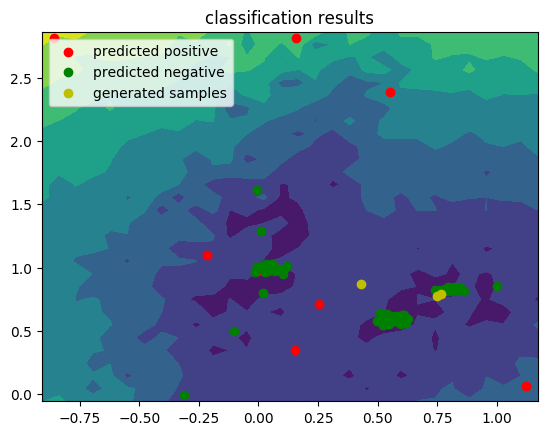

In [16]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

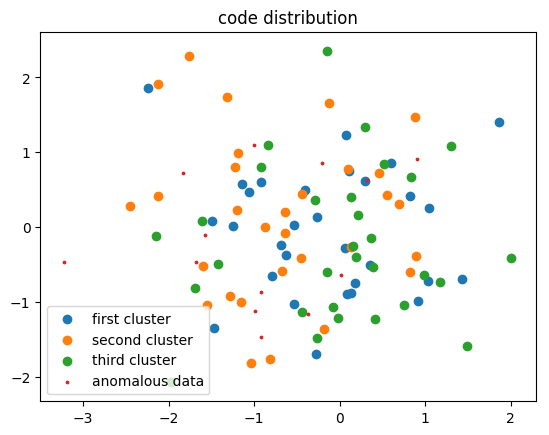

In [17]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

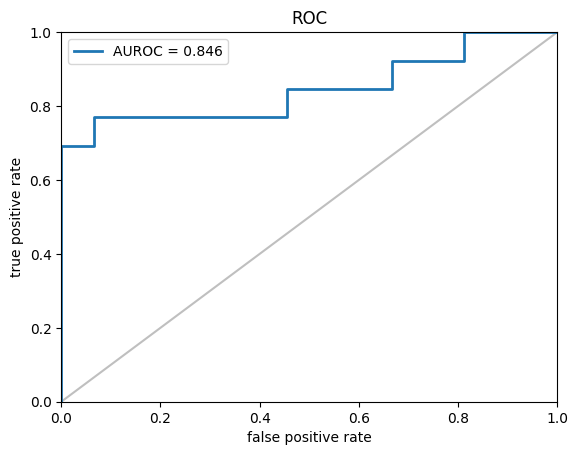

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),digits=3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()

In [19]:
using MLBase: false_positive_rate, false_negative_rate
n = 21
alphavec = range(0,stop=1,length=n)
eervec = zeros(n)
for i in 1:n
    model.alpha = alphavec[i]
    AnomalyDetection.setthreshold!(model, X)
    global tryhat, tsthat, trroc, tstroc = AnomalyDetection.rocstats(dataset.data, dataset.labels,
        dataset.data, dataset.labels, model, verb = false)
    eervec[i] = (false_positive_rate(tstroc) + false_negative_rate(tstroc))/2
end

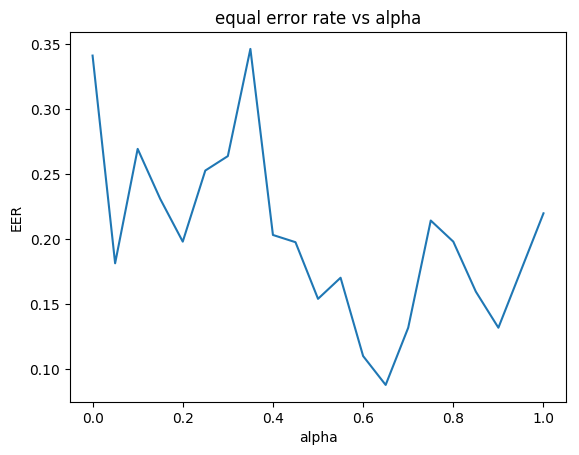

In [20]:
f = figure()
plot(alphavec, eervec)
title("equal error rate vs alpha")
xlabel("alpha")
ylabel("EER")
show()